In [176]:
import pandas as pd

data = pd.read_csv('strokeData.csv')

#check for null 
data.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [177]:
"""fill missing values for bmi using median as more accurate, as mean skewed
by extreme data and mode can be skewed by outliers
"""
data['bmi'].fillna(data['bmi'].median(), inplace=True)
data.head()

C:\Users\ethan\AppData\Local\Temp\ipykernel_18048\798860560.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [178]:
#drop non essential data that would be used to predict stroke, use new data frame
dataFiltered = data.copy()
#stroke dropped as we are predicting and id is identifier and no related
dataFiltered.drop(['id'],axis=1,inplace=True)
'''encode the data as categorical data is not allowed in machine learning
hot encoding as no order or hierarchy
'''
dataFiltered = pd.get_dummies(dataFiltered, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

#correlation test to see what to drop
dataFiltered.corr()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
age,1.000000,0.276398,0.263796,0.238171,0.324296,0.245257,0.027924,-0.027623,-0.010659,-0.679125,...,-0.078653,0.116534,0.327989,-0.634215,-0.014180,0.014180,-0.378231,0.236897,0.119307,0.073133
hypertension,0.276398,1.000000,0.108306,0.174474,0.158293,0.127904,-0.021143,0.021275,-0.004597,-0.164243,...,-0.021608,-0.005413,0.115442,-0.129506,0.007913,-0.007913,-0.141501,0.058853,0.065063,0.031240
heart_disease,0.263796,0.108306,1.000000,0.161857,0.036916,0.134914,-0.085617,0.085717,-0.003343,-0.114644,...,-0.015712,0.000027,0.086760,-0.091634,-0.003092,0.003092,-0.066731,0.066804,-0.021856,0.044049
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.166876,0.131945,-0.054902,0.054580,0.011489,-0.155068,...,-0.014675,0.016588,0.062694,-0.102250,0.004946,-0.004946,-0.095131,0.068111,0.023885,0.017646
bmi,0.324296,0.158293,0.036916,0.166876,1.000000,0.036110,0.026642,-0.026310,-0.011743,-0.334911,...,-0.028327,0.203886,0.070160,-0.442102,0.000277,-0.000277,-0.264915,0.103533,0.107636,0.084392
stroke,0.245257,0.127904,0.134914,0.131945,0.036110,1.000000,-0.009027,0.009117,-0.003166,-0.108340,...,-0.014882,0.011888,0.062168,-0.083869,-0.015458,0.015458,-0.055892,0.064556,-0.004129,0.008939
gender_Female,0.027924,-0.021143,-0.085617,-0.054902,0.026642,-0.009027,1.000000,-0.999597,-0.016642,-0.030483,...,-0.011469,0.032294,0.026143,-0.089120,-0.006340,0.006340,-0.059393,-0.043603,0.099111,-0.011306
gender_Male,-0.027623,0.021275,0.085717,0.054580,-0.026310,0.009117,-0.999597,1.000000,-0.011757,0.029936,...,0.011496,-0.032639,-0.025971,0.089283,0.005937,-0.005937,0.059658,0.042738,-0.098813,0.011477
gender_Other,-0.010659,-0.004597,-0.003343,0.011489,-0.011743,-0.003166,-0.016642,-0.011757,1.000000,0.019327,...,-0.000920,0.012092,-0.006112,-0.005514,0.014217,-0.014217,-0.009206,0.030568,-0.010728,-0.005978
ever_married_No,-0.679125,-0.164243,-0.114644,-0.155068,-0.334911,-0.108340,-0.030483,0.029936,0.019327,1.000000,...,0.090838,-0.153830,-0.192716,0.544441,0.006261,-0.006261,0.332081,-0.171256,-0.102845,-0.105226


In [179]:
#target and input data
predictors = dataFiltered.drop(columns=['stroke','gender_Female','gender_Male','gender_Other','Residence_type_Rural','Residence_type_Urban','smoking_status_Unknown','smoking_status_formerly smoked','smoking_status_never smoked','smoking_status_smokes','smoking_status_smokes','work_type_Govt_job'])
target = dataFiltered['stroke']

from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression

#split data into test and train data
X_train,X_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)

In [180]:
#create model and train and predict
model = LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [181]:
#evaluate model by using r^2 value
r_squared = model.score(predictors,target)
print('Score = ',r_squared)

Score =  0.08320719401378429


In [208]:
#using classifir as its for 1 and 0s, as if they have discrete labels or classes
from sklearn.ensemble import RandomForestClassifier
#importing accuracy_score to see how many of it matches
from sklearn.metrics import accuracy_score

'''
Creating a loop to adjust parameters of RandomForestClassifier to get a even better score
'''
n_estimatorsList = []
accuracyList = []
scoreList = []


for n_estimators in range(100,1000,100):
    #declaring model and training model
    rf = RandomForestClassifier(n_estimators)
    rf.fit(X_train,y_train)
    #predicting
    y_pred = rf.predict(X_test)
    #storing accuracy and r^2 valued
    accuracy = accuracy_score(y_test, y_pred)
    score= rf.score(X_test,y_test)
    print(accuracy)
    print(score)

    #append to list
    n_estimatorsList.append(n_estimators)
    accuracyList.append(accuracy)
    scoreList.append(score)


[0.9380300065231572, 0.9386823222439661, 0.9380300065231572, 0.9380300065231572, 0.9393346379647749, 0.9386823222439661, 0.9386823222439661, 0.9393346379647749, 0.9386823222439661]
[0.9380300065231572, 0.9386823222439661, 0.9380300065231572, 0.9380300065231572, 0.9393346379647749, 0.9386823222439661, 0.9386823222439661, 0.9393346379647749, 0.9386823222439661]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


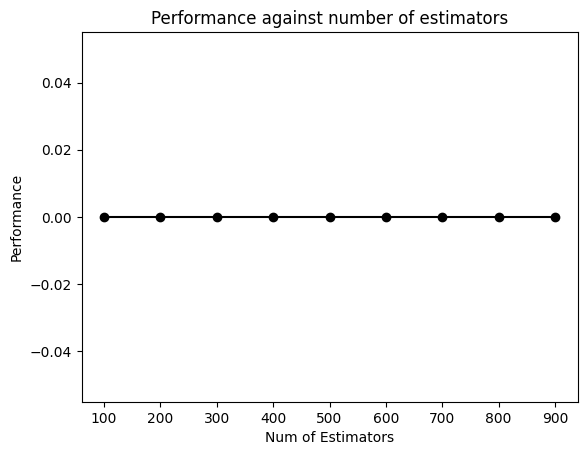

In [222]:
#plot graph
import matplotlib.pyplot as plt
import numpy as np
print(accuracyList)
print(scoreList)

differenceList = np.array(scoreList) - np.array(accuracyList)
print(differenceList)
plt.plot(n_estimatorsList,differenceList, label='Accuracy',marker='o',color = 'black')

plt.title('Performance against number of estimators')
plt.xlabel('Num of Estimators')
plt.ylabel('Performance')
plt.show()

